# AGN Scattering Sim Results

First, lets import some packages, define some constants and load the file up

In [25]:
"""
The script produces a figure showing the GW peak freq. vs. L_ij angle.
All BHs have the same mass 20Msun and the initial SMA is set to 1 AU.
"""

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams["font.family"] = "serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams['axes.labelsize'] = 30
rcParams['axes.titlesize'] = 30
rcParams['axes.labelpad'] = 20

import numpy as np
import pandas as pd

sec_year = 31536000.

open_data_filename = 'RVA_0_003_01_03_1_2_3_4_5_10_15_25_45_75_90_ISO'
npz_file = np.load(open_data_filename + 'savetestarr' + '.npz')
data_all_array = npz_file['arr_0']
print(f"Number of sim files: {len(npz_file.files)}")



Number of sim files: 1


In [26]:

class ScatteringData:
    def __init__(self, fname):
        self.fname = fname
        npz_file = np.load(self.fname + 'savetestarr' + '.npz')
        self._data = npz_file['arr_0']
        self.angle_info = self.get_angle_info()

    def get_data(self, dc=0):
        tGWij_SI_arr = self._data[dc, 0, :, 2] # inspiral time of binary i,j in seconds
        fGWij_SI_arr = self._data[dc, 0, :, 4]
        return pd.DataFrame(dict(
            id_arr = self._data[dc, 0, :, 0],
            obij_arr = self._data[dc, 0, :, 1],
            tGWij_SI_arr= tGWij_SI_arr,
            fGWij_SI_arr = fGWij_SI_arr,
            ecc_A_arr = self._data[dc, 0, :, 7],  # (if > fGW_limit then = -1)
            ecc_B_arr = self._data[dc, 0, :, 8],  # (if > fGW_limit then = -1)
            Lij_ang_arr = self._data[dc, 0, :, 9],  # in degrees
        ))

    def get_angle_info(self):
        """The file name encodes some information on the interaction angle"""
        nums_in_str = self.fname.split("_")[1:]
        binary_single_interaction_angle = {}
        for i in range(len(nums_in_str)):
            angle = nums_in_str[i]
            if angle[0]=='0':
                angle = str(float("0."+angle))
            binary_single_interaction_angle.update({i:angle})
        return binary_single_interaction_angle

scat_data = ScatteringData(open_data_filename)


## Descriptions of attributes
- dc: 
    - This can take values from 0, 15 (1,2,3,4...) 
    - Each value corresponds to an initial inclination between the binary and the incoming single BH. 
    - The value in degree can be seen in the data file name: the first is 0 (co-planar), then 0.003 degrees, where the last is "ISO = isotropic"
    - Therefore, chose dc = 0 for co-planar interactions, etc.

- id_arr: 
    - id = 5 if the BHs merge during the interaction. 
    - id = 3 if BHs merge After the interaction  
    - id >= 10 if the interaction did not end

- obij_arr:
    Tells you which of the two objects that end up in a binary:
    -   1, 2 are the intial binary components
    -   3 is incoming BH
    The encoding shows which pair remains:
    - 1: (1,2) remain
    - 2: (1,3) remain
    - 3: (2,3) remain

- tGWij_SI_arr: inspiral time of resultant binary i,j in seconds.

- fGWij_SI_arr: GW peak frequence of the BBH that merges (i,j)

- ecc_B_arr: eccentricity at 10 Hz. If fGWij_SI_arr > 10 Hz then = -1.

- Lij_ang_arr: Angle between initial and final orbital angular momentum vector.


In [27]:
print("Each dataset idx corresponds to an interaction angle:")
for dc, angle in scat_data.angle_info.items():
    print(f"dc {dc}: {angle} deg")

Each dataset idx corresponds to an interaction angle:
dc 0: 0.0 deg
dc 1: 0.003 deg
dc 2: 0.01 deg
dc 3: 0.03 deg
dc 4: 1 deg
dc 5: 2 deg
dc 6: 3 deg
dc 7: 4 deg
dc 8: 5 deg
dc 9: 10 deg
dc 10: 15 deg
dc 11: 25 deg
dc 12: 45 deg
dc 13: 75 deg
dc 14: 90 deg
dc 15: ISO deg


# Plots 

## GW Peak freq VS $L_{i,j}$

What does this acutllay show us???

In [66]:

from __future__ import print_function
from ipywidgets import interactive, IntSlider, Layout
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")


def plot_gw_freq_vs_Lij(dc_idx=0):
    dc_dat = scat_data.get_data(dc=dc_idx)
    pos_LTtlim = np.where(dc_dat.tGWij_SI_arr < (10 ** 5) * sec_year)[0]
    pos_GTtlim = np.where(dc_dat.tGWij_SI_arr > (10 ** 5) * sec_year)[0]

    fig = plt.figure(figsize=(8.0, 8.0))
    ax1 = fig.add_subplot(111)
    kwargs = dict(marker='.', markersize=5.0, linewidth=0,)
    ax1.plot(dc_dat.fGWij_SI_arr[pos_GTtlim], dc_dat.Lij_ang_arr[pos_GTtlim], color='black', label="Before Merger", **kwargs)                      
    ax1.plot(dc_dat.fGWij_SI_arr[pos_LTtlim], dc_dat.Lij_ang_arr[pos_LTtlim], color='red', label="After Merger", **kwargs)
    ax1.set_xlim(1e-8, 1e4)
    ax1.set_ylim(0, 180)
    ax1.set_xscale('log')
    ax1.set_xlabel("GW Peak Freq")
    ax1.set_ylabel(r"$L_{ij}$ angle")
    plt.title(f"Impact Angle: {scat_data.get_angle_info()[dc_idx]} deg")
    plt.legend(frameon=False, markerscale=3, loc="upper right", bbox_to_anchor=(1.5, 1))
    plt.show()
    

interactive_plot = interactive(
    plot_gw_freq_vs_Lij,
    dc_idx=IntSlider(min=0, max=15, setp=1, continuous_update=False),
    save=False
)
output = interactive_plot.children[-1]
output.layout.height = '1000px'

interactive_plot



interactive(children=(IntSlider(value=0, continuous_update=False, description='dc_idx', max=15), Output(layout…

In [ ]:
dc_dat = scat_data.get_data(dc=1)
pos_LTtlim = np.where(dc_dat.tGWij_SI_arr < (10 ** 5) * sec_year)[0]
pos_GTtlim = np.where(dc_dat.tGWij_SI_arr > (10 ** 5) * sec_year)[0]

fig = plt.figure(figsize=(8.0, 8.0))
ax1 = fig.add_subplot(111)
kwargs = dict(marker='.', markersize=5.0, linewidth=0,)
ax1.plot(dc_dat.fGWij_SI_arr[pos_GTtlim], dc_dat.Lij_ang_arr[pos_GTtlim], color='black', label="Before Merger", **kwargs)                      
ax1.plot(dc_dat.fGWij_SI_arr[pos_LTtlim], dc_dat.Lij_ang_arr[pos_LTtlim], color='red', label="After Merger", **kwargs)
ax1.set_xlim(1e-8, 1e4)
ax1.set_ylim(0, 180)
ax1.set_xscale('log')
ax1.set_xlabel("GW Peak Freq")
ax1.set_ylabel(r"$L_{ij}$ angle")
plt.title(f"Impact Angle: {scat_data.get_angle_info()[dc_idx]} deg")
plt.legend(frameon=False, markerscale=3, loc="upper right", bbox_to_anchor=(1.5, 1))
plt.show()

In [68]:
dc_dat = scat_data.get_data(dc=1)
dc_dat

,id_arr,obij_arr,tGWij_SI_arr,fGWij_SI_arr,ecc_A_arr,ecc_B_arr,Lij_ang_arr
0,3.0,3.0,2.474837e+20,0.000001,0.000011,7.587139e-09,0.114129
1,3.0,3.0,1.017602e+20,0.000002,0.000030,2.024746e-08,179.856360
2,3.0,1.0,5.160284e+17,0.000020,0.000512,3.484310e-07,0.090860
3,3.0,2.0,5.372646e+19,0.000003,0.000076,5.190963e-08,0.144992
4,3.0,3.0,9.496020e+18,0.000008,0.000193,1.314759e-07,179.651022
...,...,...,...,...,...,...,...
49995,3.0,1.0,1.202510e+17,0.000051,0.001497,1.017847e-06,0.164055
49996,3.0,3.0,8.404751e+19,0.000002,0.000028,1.904865e-08,0.097560
49997,3.0,3.0,3.086777e+19,0.000004,0.000088,5.987205e-08,0.022720
49998,3.0,2.0,1.752120e+18,0.000012,0.000288,1.960966e-07,0.050437


## Kick calculations

In [36]:
from bbh_simulator.black_hole import BlackHole, merge_bbh_pair

remnant = merge_bbh_pair(
    bh_1=BlackHole(mass=s.mass_1_source, spin=[s.spin_1x, s.spin_1y, s.spin_1z]),
    bh_2=BlackHole(mass=s.mass_2_source, spin=[s.spin_2x, s.spin_2y, s.spin_2z]),
)
print(remnant.to_dict())



Loaded NRSur7dq4Remnant fit.


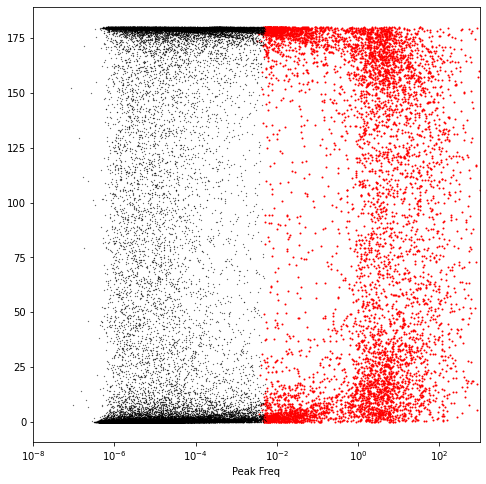

In [58]:
open_data_filename          = 'RVA_0_003_01_03_1_2_3_4_5_10_15_25_45_75_90_ISO'
data_all_array              = np.load(open_data_filename + 'savetestarr' + '.npz')['arr_0']
#define:
sec_year        = 31536000.
dc  = 2         #dataset index.
id_arr          = data_all_array[dc, 0, :, 0]          
obij_arr        = data_all_array[dc, 0, :, 1]
tGWij_SI_arr    = data_all_array[dc, 0, :, 2]
fGWij_SI_arr    = data_all_array[dc, 0, :, 4]
ecc_A_arr       = data_all_array[dc, 0, :, 7]   #(if > fGW_limit then = -1)
ecc_B_arr       = data_all_array[dc, 0, :, 8]   #(if > fGW_limit then = -1)
Lij_ang_arr     = data_all_array[dc, 0, :, 9]   #in degrees
pos_LTtlim        = np.where(tGWij_SI_arr < (10**5)*sec_year)
pos_GTtlim        = np.where(tGWij_SI_arr > (10**5)*sec_year)    
#plot:
fig = plt.figure(figsize=(8.0, 8.0))
ax1 = fig.add_subplot(111)
ax1.plot(fGWij_SI_arr[pos_LTtlim], Lij_ang_arr[pos_LTtlim], marker = '.', markersize = 2.0, linewidth = 0, color = 'red')
ax1.plot(fGWij_SI_arr[pos_GTtlim], Lij_ang_arr[pos_GTtlim], marker = '.', markersize = 0.5, linewidth = 0, color = 'black')
ax1.set_xlim(1e-8,1e3)
ax1.set_xscale('log')
ax1.set_xlabel("Peak Freq")
#show:
plt.show()    

### NOTES:

ec and angle relation? 

kick as function of ecc

scatter plot of vectors (direciton of vel)

how th e kick looks EM counterpart


higher the eccentricity, smaller the J, and so easier it to flip the BBH

peak freq is associated with pericenter (almost constant) of binary until orbit circular, after which the peak freq increases

peak freq == 2* orb freq 